In [1]:
%cd ..

/home/dani2442/Projects/Functional-Data-Analysis


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from main import ffpca, fpca

In [3]:
train_df = pd.read_pickle("data/esa-adb-challenge/train.pkl")
test_df = pd.read_pickle("data/esa-adb-challenge/test.pkl")

#channel_names = [f"channel_{x}" for x in [12, 13, 17, 18, 19, 20, 25, 26, 27, 28, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, ]] #57, 58, 59]]
channel_names = [f"channel_{x}" for x in [42, 43, 44, 45, 46]] #57, 58, 59]]

In [4]:
x_train = train_df[channel_names]
y_train = train_df["is_anomaly"]

#x_train = x_train.rolling(15, center=True).median()
#x_train = (x_train - x_train.mean()) / x_train.std()
#x_train.to_pickle("data/esa-adb-challenge/x_train_mini.pkl")
x_train = pd.read_pickle("data/esa-adb-challenge/x_train_mini.pkl")

## Standard Preprocess of data

In [5]:
x_train.describe()

,channel_42,channel_43,channel_44,channel_45,channel_46
count,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07,1.472831e+07
mean,-1.756621e-15,1.054966e-15,-1.213579e-15,-2.301246e-16,-1.718424e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.532174e+01,-2.409692e+01,-2.297262e+01,-2.582097e+01,-2.519210e+01
25%,-1.250101e-01,-6.984318e-02,-7.786586e-02,-9.170119e-02,-1.277817e-01
50%,5.703568e-02,5.419594e-02,5.879994e-02,4.336733e-02,3.890981e-02
75%,2.390370e-01,1.782351e-01,1.954261e-01,2.054754e-01,2.333365e-01
max,5.751925e+00,5.636033e+00,5.114890e+00,6.013817e+00,6.234048e+00


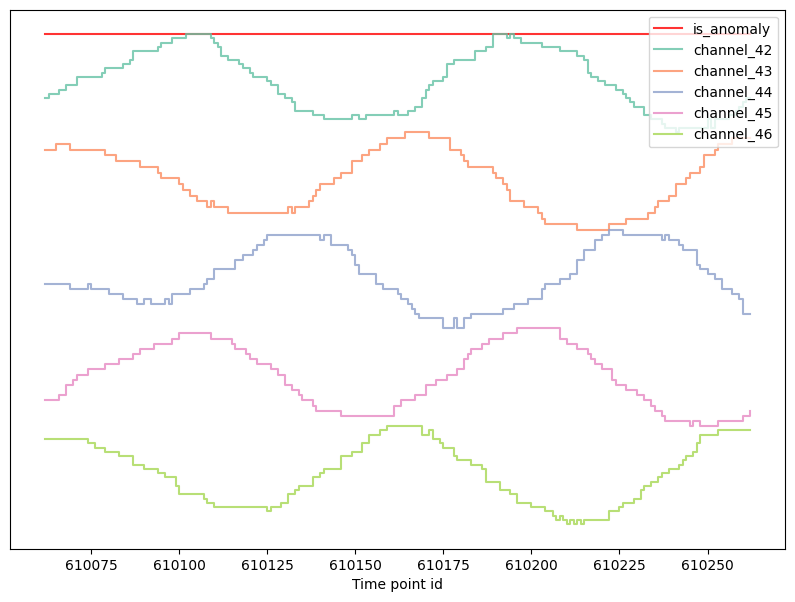

In [10]:
plt.rcParams["image.cmap"] = "Set2"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
plt.figure(figsize=(10,7))

start_idx = 610062
end_idx = start_idx + 200

plt.step(np.arange(start_idx,end_idx+1), train_df.loc[start_idx:end_idx, "is_anomaly"] + 1, alpha=0.8, label="is_anomaly", where="post", color="red")

for i, channel in enumerate(channel_names):
    d = x_train.loc[start_idx:end_idx, channel]
    d = (d - np.min(d))/(np.max(d) - np.min(d))

    plt.step(np.arange(start_idx,end_idx+1), d - i, alpha=0.8, label=channel, where="post")

plt.xlabel("Time point id")
plt.yticks([], [])
plt.legend(loc="upper right")

In [12]:
a = np.zeros((200,100,10))
np.mean(a, axis=1, keepdims=True).shape

(200, 1, 10)

In [28]:
N = 400 # window size
n = 100 # samples to estimate the covariance
bs = 256

In [ ]:
p = x_train.shape[1]
max_start = x_train.shape[0]-N

cov = np.zeros((N, p, p))
cov_hat = np.zeros((N, p, p))
mu_hat = np.zeros((N, 1, p))
mu = np.zeros((N, 1, p))

for i in tqdm(range(1,n+1)):
    starts = np.random.randint(0, max_start, size=bs)
    windows = [x_train.iloc[start:start+N].to_numpy() for start in starts]
    x = np.stack(windows).transpose(1,0,2)
    
    x_hat = np.fft.fft(x, axis=0)
    mu_hat_i = np.mean(x_hat, axis=1, keepdims=True)
    mu_hat = (mu_hat + mu_hat_i/(i*bs)) * (i/(i+1))

    x_hat = x_hat - mu_hat

    cov_i = x.transpose(0,2,1) @ x
    cov_hat_i = x_hat.transpose(0,2,1) @ x_hat

    cov = (cov + cov_i/(i*bs)) *(i/(i+1))
    cov_hat = (cov_hat + cov_hat_i/(i*bs)) *(i/(i+1))
    

np.save("data/cov_mini.npy", cov)
np.save("data/cov_hat_mini.npy", cov_hat)
np.save("data/mu_mini.npy", mu)
np.save("data/mu_hat_mini.npy", mu_hat)

100%|██████████| 100/100 [00:01<00:00, 57.49it/s]


In [16]:
cov = np.load("data/cov_mini.npy")
cov_hat = np.load("data/cov_hat_mini.npy")
mu = np.load("data/mu_mini.npy")
mu_hat = np.load("data/mu_hat_mini.npy")

In [17]:
from fpca import FPCA, FFPCA

In [18]:
fpca1 = FPCA()
ffpca1 = FFPCA()
fpca1.set_eigenvectors(cov)
fpca1.set_mean(mu)
ffpca1.set_eigenvectors(cov_hat)
ffpca1.set_mean(mu_hat)

In [87]:
t_start = 900000
t_step = 5
t_end = 2000000
t = np.arange(t_start, t_end, t_step)
r1, r2 = np.zeros_like(t, dtype=np.float32), np.zeros_like(t, dtype=np.float32)

def error(x1, x2):
    return np.mean(np.square(x1.real - x2.real))

In [88]:
for i, ti in tqdm(enumerate(t), total=len(t)):
    x = np.expand_dims(x_train.loc[ti-N+1:ti].to_numpy(), axis=1)
    y1 = fpca1.transform(x, 1)
    y2 = ffpca1.transform(x, 1)

    r1[i] = error(x, y1)
    r2[i] = error(x, y2)

100%|██████████| 220000/220000 [00:47<00:00, 4590.07it/s]


[]

/home/dani2442/Projects/Functional-Data-Analysis/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


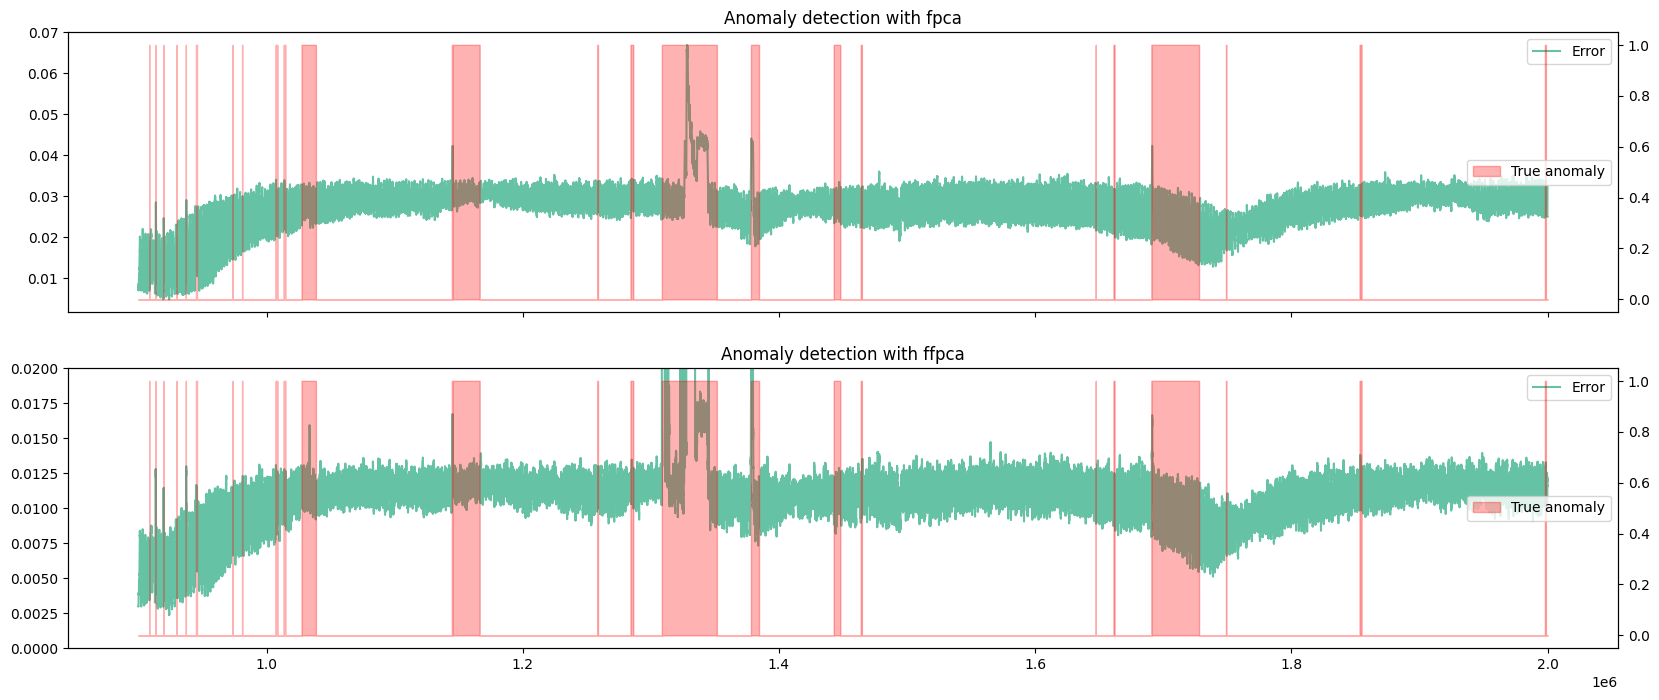

In [110]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
# Plot the Series
y_train_loc = y_train.loc[t_start:t_end]

# Plot the numpy arrays

ax2 = axes[0].twinx()
ax2.fill_between(y_train_loc.index, 0, y_train_loc.values, color='red', alpha=0.3, label="True anomaly")
axes[0].plot(t, r1, label="Error")
axes[0].set_title('Anomaly detection with fpca')
axes[0].legend()
ax2.legend()


axes[1].plot(t, r2, label="Error")
ax2b = axes[1].twinx()
ax2b.fill_between(y_train_loc.index, 0, y_train_loc.values, color='red', alpha=0.3, label="True anomaly")

axes[1].set_title('Anomaly detection with ffpca')
axes[1].set_ylim((0,0.02))
axes[1].legend()
ax2b.legend()

#axes[0].set_zorder(6)
#axes[1].set_zorder(6)
#ax2.set_zorder(5)
#ax2b.set_zorder(5)
fig.savefig("images/anomaly_detection_v2.png", dpi=300)
plt.plot()

In [83]:
ti = t_start

0.007192741899246682
0.0029683669948912597


<Axes: >

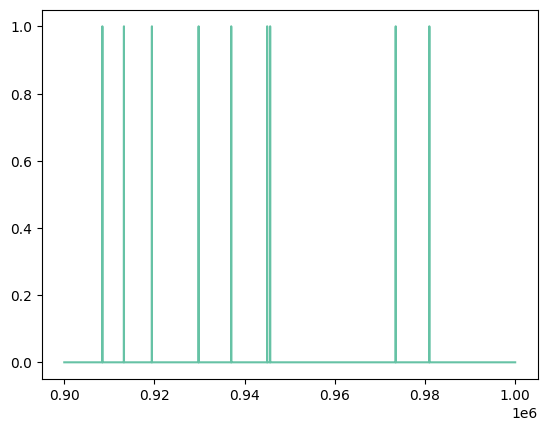

In [29]:
y_train.loc[900000:1000000].plot()

In [ ]:
t = np.linspace()

0           0
1           0
2           0
3           0
4           0
           ..
14728316    0
14728317    0
14728318    0
14728319    0
14728320    0
Name: is_anomaly, Length: 14728321, dtype: uint8